<a href="https://colab.research.google.com/github/LilySu/DS-Unit-2-Classification-2/blob/master/Making_explaining_decisions_LL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Classification 2_ 

# Making & explaining decisions

### Objectives
- Make decisions with probability calibration and expected value calculations
- Explain decisions with shapley value plots

### Libraries

#### category_encoders
- Local Anaconda: `conda install -c conda-forge category_encoders`
- Google Colab: `pip install category_encoders`

#### [shap](https://github.com/slundberg/shap) (for shapley value plots)
- Local Anaconda: `conda install -c conda-forge shap` ***(I'm getting import errors locally)***
- Google Colab: `pip install shap`

#### [tqdm](https://tqdm.github.io/) (for progress bars)
- Local Anaconda: `conda install -c conda-forge tqdm`
- Google Colab: Already installed


In [1]:
!pip install category_encoders

In [2]:
!pip install shap

     |████████████████████████████████| 235kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/14/42/0c/c07f5fdfb68e06b525d2ba984f50c83f1e5ebd3d2680852aa5
Successfully built shap


## Lending Club Review 🏦

This sprint, your project is with Lending Club data, historical and current. Predict if peer-to-peer loans are charged off or fully paid. Decide which loans to invest in.

#### Changes from the previous lesson
- Engineer more date features
- After splitting the data, but before wrangling it, save the actual results (percent of each loan repaid) for each set, to compare later with the predicted results
- Engineer and select different features in the wrangle function
- Use xgboost instead of random forest

In [0]:
history_location = '../data/lending-club-subset.csv'
current_location = '../data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

# # For Google Colab, uncomment:
history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

In [0]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Current loans available for manual investing, June 17, 2019
# Source: https://www.lendingclub.com/browse/browse.action
current = pd.read_csv(current_location)

In [0]:
# Transform earliest_cr_line to an integer:
# How many days the earliest credit line was open, before the loan was issued.
# For current loans available for manual investing, assume the loan will be issued today.
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

# Transform earliest_cr_line for the secondary applicant
history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

# Engineer features for issue date year & month
history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month


In [0]:
# Calculate percent of each loan repaid
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']#we can create our own target column to set up as a regression problem
#instead of best case or worst case, we can model a range of scenarios, also loans are early there are less returns

In [0]:
# Train on the historical data.
# For the target, use `loan_status` ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

In [8]:
# Do train/validate/test 3-way split
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [9]:
# Save the actual results, to compare later with predicted results
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']#saving the results, mainly precent paid, what grade it was, the id, term and interest rate
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()
#what was my estimated probabiliy of loan paid by full, estimated by best case scenario
#worst case outcome of loosing 25 dollars multiplied by previous**review this at 15min in
result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [0]:
# Use Python sets to compare the historical columns & current columns
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

In [0]:
# For features, use only the common columns shared by the historical & current data.
features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [12]:
def wrangle(X):
    X = X.copy()

    # Engineer new feature for every feature: is the feature null?
    for col in X:
        X[col+'_NULL'] = X[col].isnull()#keep null values after the fact, the model could handle nulls
    
    # Convert percentages from strings to floats
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    # Convert employment length from string to float
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)#strip the non-digit codes (match any code not digit replace with empty string)#left with number of years employed
        
    # Create features for three employee titles: teacher, manager, owner
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()#grabbing the length of text field
    
    # Convert sub_grade from string "A1"-"D5" to integer 1-20
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, #subgrade strings to integers
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # Drop some columns
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='member_id') # Always null
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality. lots of unique values, meaningless and random, weak correlation, to eliminate coincidental patterns that might get assigned vs weak but real correlations
    
    # Only use these features which had nonzero permutation importances in earlier models    
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    # Return the wrangled dataframe
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [13]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', #roc auc
          early_stopping_rounds=10)

[0]	validation_0-auc:0.669638	validation_1-auc:0.672822
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.670802	validation_1-auc:0.674118
[2]	validation_0-auc:0.676142	validation_1-auc:0.680087
[3]	validation_0-auc:0.679771	validation_1-auc:0.683186
[4]	validation_0-auc:0.682482	validation_1-auc:0.684256
[5]	validation_0-auc:0.683905	validation_1-auc:0.685868
[6]	validation_0-auc:0.685104	validation_1-auc:0.687372
[7]	validation_0-auc:0.685857	validation_1-auc:0.687737
[8]	validation_0-auc:0.685805	validation_1-auc:0.687888
[9]	validation_0-auc:0.686504	validation_1-auc:0.689168
[10]	validation_0-auc:0.686866	validation_1-auc:0.689461
[11]	validation_0-auc:0.686938	validation_1-auc:0.689288
[12]	validation_0-auc:0.687537	validation_1-auc:0.69022
[13]	validation_0-auc:0.688371	validation_1-auc:0.690954
[14]	validation_0-auc:0.688811	validation_1-auc:0.691599

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
#early stopping class
# class XGRegressorEval(XGBRegressor):
#   def fit(self, *args, **kwargs):
#     return super().fit(*args, eval_set=eval_set, eval_metric='rmse', 
#           early_stopping_rounds=10, **kwargs)
    
# pipeline = make_pipeline(ce.OrdinalEncoder(), XGRegressorEval(n_estimators=1000, n_jobs=-1))

## Make decisions with probability calibration and expected value calculations

### Probability calibration

#### Scikit-Learn User Guide, [Probability calibration](https://scikit-learn.org/stable/modules/calibration.html)

> When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. 

> Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class. The following plot compares how well the probabilistic predictions of different classifiers are calibrated:

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_compare_calibration_0011.png" width="500">

> LogisticRegression returns well calibrated predictions by default as it directly optimizes log-loss. In contrast, the other methods return biased probabilities; with different biases per method ...

#### Jason Brownlee, [How and When to Use a Calibrated Classification Model with scikit-learn](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)

> **You can diagnose the calibration of a classifier by creating a reliability diagram** of the actual probabilities versus the predicted probabilities on a test set.

> In scikit-learn, this is called a calibration curve. This can be implemented by first calculating the [`calibration_curve()` function](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html). This function takes the true class values for a dataset and the predicted probabilities for the main class (class=1). The function returns the true probabilities for each bin and the predicted probabilities for each bin. The number of bins can be specified via the `n_bins` argument and default to 5.

We can check our calibration curves and see that the probabilities are already reasonably well calibrated.

[XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier) has a default parameter, `objective='binary:logistic'`. Like Logistic Regression, it returns well calibrated predictions by default. 

(However, if we'd used RandomForestClassifier, we'd likely need to calibrate its predictions using scikit-learn's CalibratedClassifierCV class.) 

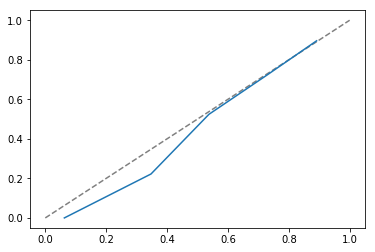

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);
#reasonably well calibrated

#you pass in ground truth on a set that you did not train on, and probability of positive class
#it bins 5 together - of the true labels, what is the true probabilities 

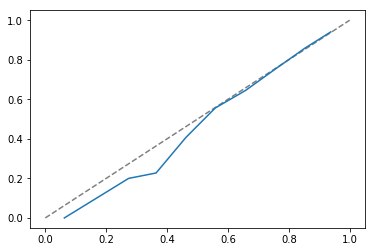

In [16]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

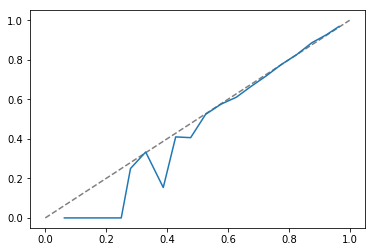

In [17]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);#picking to the right of median, the bulk of bell curve, are well-calibrated
#optimizing log loss
#linear regression is optimizing for sum of squared error
#classification -with gradient boosting optimizing for log-loss like logistic regression, roc auc to control early stopping **review at 45min
#check our calibration, no need to fix our calibration

### Expected value calculations

In [0]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)######can be run only once
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] #shouldn't be too much of extreme
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])#extreme that doesn't occur often, negative value for undesireable case
    #what is our probability of good case, multipled by monetary value, mutually collective, collectively exhaustive
    return result_df

result_val = get_results(result_val, y_val, y_pred_proba)
#my risk tolerance, am I able to tolerate 1% of time
#use predicted probability, also best and worst case in the unit of dollars, also lower predicted probability
#model should be useful if it helps identify some loans that don't have best grade but may be likely to be repaid and vise versa

In [19]:
result_val.head()#converting term to numer of months
#we care about sorting on loans on risk and reward

#max interest from remaining principal

#if it helps me to sort in combined probability and take risk into account it can be useful

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
47563,11336218.0,2014-01-01,D,1.439103,60,16.99,Fully Paid,0.807333,84.95,46.2375,-25,32.512418
83314,127629418.0,2018-01-01,D,1.172302,36,20.00,Fully Paid,0.765229,60.00,40.0000,-25,24.739869
740,555478.0,2010-08-01,D,1.217144,36,15.95,Fully Paid,0.766133,47.85,36.9625,-25,22.471513
60350,106493943.0,2017-04-01,C,1.158069,60,12.74,Fully Paid,0.766844,63.70,40.9250,-25,25.554169
121119,68368766.0,2016-01-01,A,1.048598,36,5.32,Fully Paid,0.974245,15.96,28.9900,-25,27.599482


In [20]:
result_val.describe()

,id,percent_paid,term,int_rate,pred_proba,max_interest,best_case,worst_case,expected_value
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000
mean,5.959835e+07,1.041970,40.756800,12.189265,0.824422,42.334759,35.583690,-25.0,24.559822
std,3.961624e+07,0.267876,9.567687,3.723483,0.111570,19.270011,4.817503,0.0,4.981321
min,1.336850e+05,0.000000,36.000000,5.310000,0.062601,15.930000,28.982500,-25.0,-20.191494
25%,2.274274e+07,1.044298,36.000000,9.170000,0.760635,28.320000,32.080000,-25.0,22.344073
50%,6.136165e+07,1.113421,36.000000,12.130000,0.846522,38.220000,34.555000,-25.0,25.853340
75%,8.869767e+07,1.182077,36.000000,14.672500,0.910214,50.970000,37.742500,-25.0,27.751755
max,1.493697e+08,1.599994,60.000000,28.800000,0.990894,144.000000,61.000000,-25.0,52.219850


In [0]:
%matplotlib inline
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(df, n_picks=40, n_sims=10000, #pick minimum of 40, number of times repeating simulation
             grades=['A','B','C','D'], #loan grades to invest in 
             start_date='2007-07-01', 
             end_date='2019-03-01', 
             min_expected_value=-25):#sets cutoff as new strategy, what if I only consider loans , my model estimates a certain expected value
  #percent paid is actually repaid
    """
    What if you picked random loans for $25 investments?
    How much would you have been paid back?
    
    Repeat the simulation many times, and plot the distribution 
    of probable outcomes.
    
    This doesn't consider fees or "time value of money."
    """
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start_date) &
                 (df['issue_d'] <= end_date) & 
                 (df['expected_value'] >= min_expected_value))
    possible = df[condition]
    
    simulations = []
    for _ in tnrange(n_sims):
        picks = possible.sample(n_picks).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    print(f'#### {n_picks} loans picked from {len(possible)} possible loans')
    print(f'- Dates: {start_date}-{end_date}\n' + 
                     f'- Grades: {grades}\n' +
                     f'- Expected Value >= {min_expected_value}')
    print(f'#### Range of results from {n_sims} simulations')
    print(simulations.describe().to_string())
    plt.title(f'{percent}% of simulations did not profit.')
    
    #I'm only picking the first 20

### What if we picked loans randomly?


#### 40 loans picked from 20000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1040.969750
std         42.787650
min        851.021817
25%       1013.350354
50%       1043.302337
75%       1070.637610
max       1173.758454


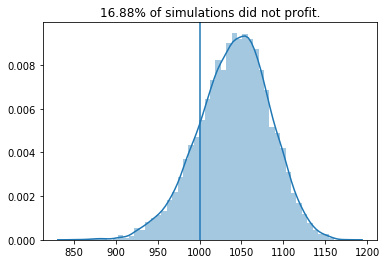

In [22]:
simulate(result_val)

### What if we picked grade 'A' loans only?


#### 40 loans picked from 3986 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1051.722389
std         23.418714
min        921.245114
25%       1037.591647
50%       1054.846749
75%       1068.688660
max       1100.927052


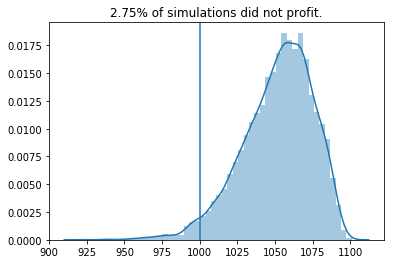

In [23]:
simulate(result_val, grades=['A'])#20 percent of loans what I say are best 20 percent based on potential reward, in less than 3% of situations I did not profit

### What if we picked loans using the model?


#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 28.10330103009939
#### Range of results from 10000 simulations
count    10000.000000
mean      1098.734009
std         34.867244
min        947.080363
25%       1076.416410
50%       1100.883409
75%       1123.149790
max       1197.918055


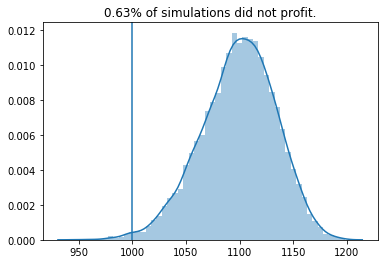

In [24]:
import numpy as np
min_expected_value = np.percentile(result_val['expected_value'], 80)#expected value of $28 dollars, that model did not fit, 1%, 75%percentile outcome
simulate(result_val, min_expected_value=min_expected_value)

#start off with 10000, left with 1098
#was expected value at the top 20%

#to get the best range of estimates - cross validation or loans above this scores are best loans

### Test Time!

https://twitter.com/Zach_Angell/status/1107982917463085056

In [25]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))#true test is looking at test set
#categpory encoders, mean imputation, similar to validation

Test ROC AUC: 0.709825059932263



#### 40 loans picked from 4000 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expected Value >= 28.10353728312254
#### Range of results from 10000 simulations
count    10000.000000
mean      1092.689191
std         35.979455
min        930.045223
25%       1069.890464
50%       1094.822142
75%       1117.740870
max       1206.492198


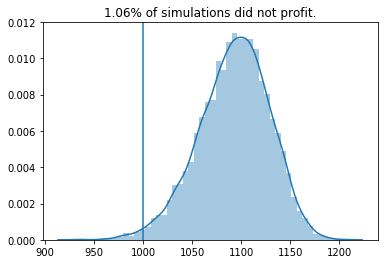

In [26]:
import numpy as np
result_test = get_results(result_test, y_test, y_pred_proba)#passing in info from test set, and predicted probabilities, similar to results_val
min_expected_value = np.percentile(result_test['expected_value'], 80)
simulate(result_test, min_expected_value=min_expected_value)

#idempotent - property can be applied multiple times - some code we have above 

## Explain decisions with shapley value plots

### We're learning about 3 types of model explanations this unit:

Linear models give you all three following interpretations from coefficients, for trees and black box models:

#### Global explanation: all features in relation to each other
What features have the most impact on my model's predictions?

- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### Global explanation: individual feature(s) in relation to target
What does my model predict if I vary some feature(s) and hold the other features constant?

- Partial Dependence plots

#### Individual prediction explanation
Why does my model make this prediction for this individual observation? 

- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

#### [Dan Becker explains Shapley Values:](https://www.kaggle.com/dansbecker/shap-values)

>You've seen (and used) techniques to extract general insights from a machine learning model. But what if you want to break down how the model works for an individual prediction?

>SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. 

>There is some complexity to the technique ... We won't go into that detail here, since it isn't critical for using the technique. [This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) has a longer theoretical explanation.

In [27]:
df = result_test.copy()
condition = (df['expected_value'] >= min_expected_value)
possible = df[condition]
picks = possible.sample(40, random_state=42).copy()
picks

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
106384,17804482.0,2014-06-01,B,1.190049,36,11.67,Fully Paid,0.915435,35.01,33.7525,-25,28.784068
110718,3196477.0,2013-01-01,D,1.332754,36,19.72,Fully Paid,0.826032,59.16,39.7900,-25,28.518593
124703,65282213.0,2015-11-01,C,1.013939,60,12.59,Fully Paid,0.824601,62.95,40.7375,-25,29.207200
2477,383777.0,2009-03-01,B,1.019927,36,11.89,Fully Paid,0.908779,35.67,33.9175,-25,28.542992
1104,6328662.0,2013-07-01,B,1.287734,60,11.55,Fully Paid,0.868784,57.75,39.4375,-25,30.982250
49571,1675962.0,2012-11-01,B,1.105050,36,10.16,Fully Paid,0.926388,30.48,32.6200,-25,28.378457
67183,7695294.0,2013-11-01,C,1.183398,60,14.30,Fully Paid,0.835548,71.50,42.8750,-25,31.712795
81982,125384326.0,2017-12-01,A,1.017289,36,7.35,Fully Paid,0.964830,22.05,30.5125,-25,28.560111
126315,144826391.0,2018-12-01,D,1.015443,36,17.97,Fully Paid,0.863518,53.91,38.4775,-25,29.813945
40826,8956766.0,2013-11-01,A,1.094453,36,8.90,Fully Paid,0.947780,26.70,31.6750,-25,28.715429


In [28]:
data_for_prediction = X_test[X_test.index==106384]
data_for_prediction

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_title_owner,fico_range_high,funded_amnt,home_ownership,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_open_acc,sec_app_open_act_il,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
106384,0.0,FL,NaN,140000.0,NaN,30333.0,26371.0,43.9,0.0,0.0,True,15.22,NaN,7548,10.0,False,16.0,False,False,724.0,33000.0,MORTGAGE,NaN,1.0,1090.88,11.67,6,2014,33000.0,NaN,205.0,247.0,28.0,3.0,True,NaN,30.0,1.0,5.0,9.0,11.0,9.0,False,True,NaN,100.0,33.3,0.0,credit_card,31786.0,NaN,NaN,NaN,NaN,NaN,9,36 months,23.0,False,0.0,615094.0,34.0,NaN,47000.0,NaN,60600.0


In [0]:
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns

In [30]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)
#base value is positive, what is our base prediction - if we didn't have any information, we'd predict the positive class
#different values that push the predicted higher or lower - red is higher probability that loan is fully paid
#assumption - 36 month loan is less risky, good subgrade (B, top half), loan amount associated with less likelyhood of being repaid

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [31]:
data_for_prediction = X_test[X_test.index==110718]
data_for_prediction

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_title_owner,fico_range_high,funded_amnt,home_ownership,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_open_acc,sec_app_open_act_il,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
110718,7.0,AZ,NaN,86000.0,NaN,14796.0,746.0,86.2,0.0,0.0,False,15.66,NaN,6850,7.0,False,35.0,False,False,664.0,21000.0,MORTGAGE,NaN,3.0,777.45,19.72,1,2013,21000.0,NaN,111.0,228.0,0.0,7.0,False,NaN,12.0,0.0,7.0,10.0,12.0,10.0,False,True,NaN,78.0,71.4,0.0,debt_consolidation,5671.0,NaN,NaN,NaN,NaN,NaN,20,36 months,10.0,False,0.0,232590.0,34.0,NaN,5400.0,NaN,8500.0


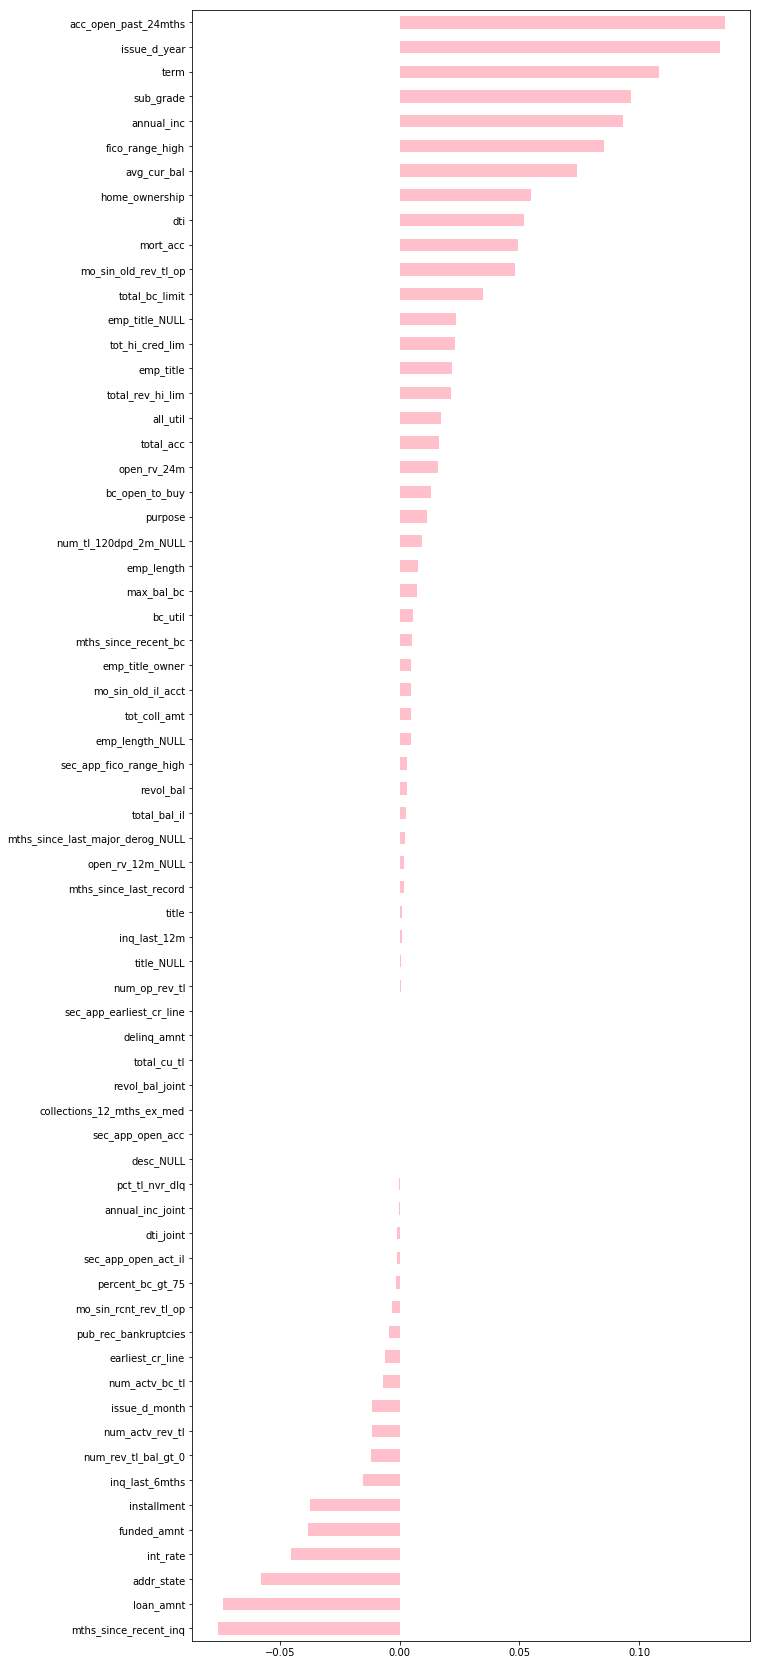

In [32]:
plt.figure(figsize=(10,30))
pd.Series(shap_values[0], X_test.columns).sort_values().plot.barh(color='pink')

In [33]:
data_for_prediction = X_test[X_test.index==120043]
data_for_prediction
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)
#could show further feature engineering - column maybe should be associated with higher loan repayment in a counterintuitive way. Is the model learning the wrong patterns

In [36]:
df = pd.DataFrame(shap_values)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65
0,-0.066378,-0.041963,0.014394,0.087251,-0.000398,-0.012074,0.018365,0.00686,0.000144,0.000296,0.0,0.177436,-0.001312,-0.002038,-0.010642,0.003927,0.043965,0.017792,0.003039,-0.054699,0.010129,0.045396,0.000841,-0.017889,-0.033896,-0.035822,0.020721,0.088221,0.042302,0.005589,0.003158,-0.046836,-0.000643,0.044374,0.00454,0.043854,-0.058728,0.015785,-0.00708,-0.025233,0.000216,-0.009891,0.00768,0.00199,0.01177,0.000237,0.009036,0.031903,0.005813,0.000616,0.000116,0.000332,0.002502,0.000031,-0.001102,0.294636,0.10619,0.000953,0.0006,0.003358,0.027734,0.058869,0.002674,-0.019878,0.000222,0.005042


In [37]:
data_for_prediction = X_test[X_test.index==110406]
data_for_prediction
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [38]:
data_for_prediction = X_test[X_test.index==20066]
data_for_prediction
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap.initjs()
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)